In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf

In [2]:
#date range
start_date = "2019-05-01" #changing the date range to test different time periods
end_date = "2021-01-31"

#assets
asset_tick = ['ETH-USD', '^IRX', 'USDC-USD']

#get data
data = yf.download(asset_tick, start=start_date, end=end_date)
data = data['Close']

data = data.ffill().bfill()

[*********************100%***********************]  3 of 3 completed


In [3]:
data_norm = pd.DataFrame(index=data.index)
for col in data.columns:
    if col != 'USDC-USD':
        data_norm[col] = ((data[col] - data[col].mean()) / data[col].std()) * 1 + 1
    else:
        data_norm['USDC-USD'] = data['USDC-USD'] / data['USDC-USD'].iloc[0]  #because USDC is already close to 1, just divide by original value

returns = data_norm.pct_change().dropna()
cov_matrix = returns.cov()

annual_target_return = 0.01
trading_days_per_year = 252
daily_target_return = (1 + annual_target_return) ** (1/trading_days_per_year) - 1

In [4]:
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

In [5]:
def portfolio_semi_variance(weights, returns):
    portfolio_returns = np.dot(returns, weights)
    negative_returns = np.minimum(portfolio_returns - daily_target_return, 0)
    return np.mean(negative_returns**2)

In [6]:
def optimize_portfolio(returns, cov_matrix, current_prices):
    n = len(returns.columns)
    def objective(weights):
        portfolio_volatility = np.sqrt(portfolio_variance(weights, cov_matrix)) * np.sqrt(252)
        semi_variance = portfolio_semi_variance(weights, returns)
        peg_deviation = abs(np.sum(weights * current_prices) - 1)
        return portfolio_volatility + semi_variance + 1000 * peg_deviation

    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  #making sure weights sum to 1
        {'type': 'eq', 'fun': lambda x: np.sum(x * current_prices) - 1}  #keeping peg at 1
    )
    bounds = tuple((0, 1) for _ in range(n))
    result = minimize(objective, n*[1./n], method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [7]:
initial_weights = optimize_portfolio(returns, cov_matrix, data_norm.iloc[0])
weights = initial_weights

stablecoin_prices = [1]
window_size = 30

In [8]:
for i in range(1, len(data_norm)):
    if i % window_size == 0:
        recent_returns = returns.iloc[max(0, i-window_size):i]
        recent_cov = recent_returns.cov()
        weights = optimize_portfolio(recent_returns, recent_cov, data_norm.iloc[i])

    stablecoin_price = np.dot(data_norm.iloc[i], weights)
    peg_adjustment = 0.95 * (1 - stablecoin_price) + stablecoin_price  # Adjust towards 1
    stablecoin_prices.append(peg_adjustment)
    if i >= window_size:
        recent_prices = data_norm.iloc[i-window_size:i]

In [9]:
# Ensure stablecoin_prices matches the length of data
if len(stablecoin_prices) < len(data_norm):
    stablecoin_prices += [1] * (len(data_norm) - len(stablecoin_prices))

data_norm['Stablecoin'] = stablecoin_prices

In [10]:
#calculating volatility
def calculate_volatility(prices, trading_days_per_year=252):
    prices_array = np.array(prices)
    
    daily_returns = (prices_array[1:] - prices_array[:-1]) / prices_array[:-1]
    daily_volatility = np.std(daily_returns)
    annual_volatility = daily_volatility * np.sqrt(trading_days_per_year)

    return annual_volatility

In [11]:
#calculating proposed stablecoin metrics
portfolio_returns = np.dot(returns, weights)
portfolio_volatility = calculate_volatility(stablecoin_prices)

#calculating USDC metrics
usdc_returns = returns['USDC-USD']
usdc_volatility = np.std(usdc_returns) * np.sqrt(trading_days_per_year)

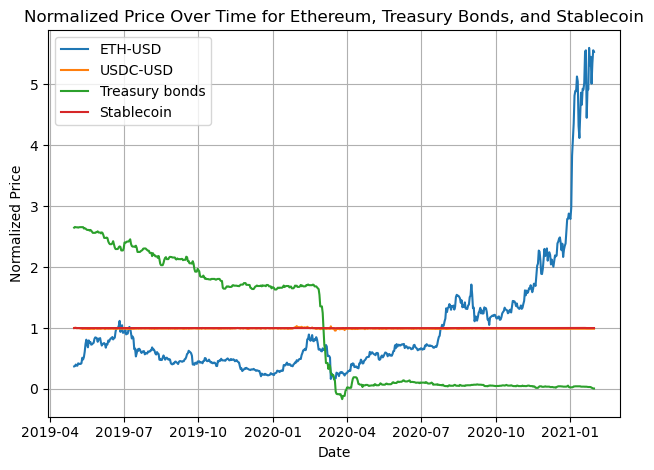

In [12]:
#Plotting graphs
for col in data_norm.columns:
    if col == '^IRX':
        plt.plot(data_norm.index, data_norm[col], label='Treasury bonds')
    else:
        plt.plot(data_norm.index, data_norm[col], label=col)

plt.title('Normalized Price Over Time for Ethereum, Treasury Bonds, and Stablecoin')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
print("Final portfolio weights: ")
for asset, weight in zip(data_norm.columns[:-1], weights): 
    print(f"{asset}: {weight:.4f}")
print("\n")

# Print volatilities
print(f"Portfolio Standard Deviation: {portfolio_volatility:.4f}")
print(f"USDC Standard Deviation: {usdc_volatility:.4f}")

Final portfolio weights: 
ETH-USD: 0.0026
USDC-USD: 0.9974
^IRX: 0.0000


Portfolio Standard Deviation: 0.0040
USDC Standard Deviation: 0.0750


[*********************100%***********************]  3 of 3 completed


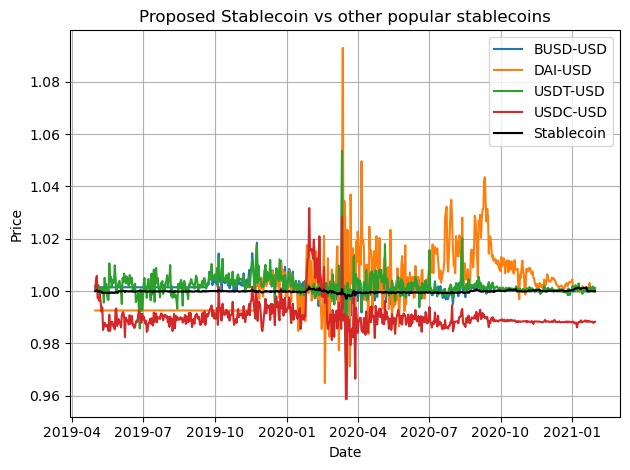

In [14]:
stablecoin_comparisons = ['DAI-USD', 'USDT-USD', 'BUSD-USD']

sc_data = yf.download(stablecoin_comparisons, start=start_date, end=end_date)
sc_data = sc_data['Close']

sc_data = sc_data.ffill().bfill()

for col in sc_data.columns:
    plt.plot(sc_data.index, sc_data[col], label=col)

for col in data_norm.columns:
    if col == 'Stablecoin':
        plt.plot(data_norm.index, data_norm[col], label=col, color = "black")
    if col == 'USDC-USD':
        plt.plot(data_norm.index, data_norm[col], label=col)

plt.title('Proposed Stablecoin vs other popular stablecoins')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()